In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# cd
import os
path = os.getcwd()
print(path)

/Users/kanazawaatsuya/imp/MQ2007/RankNet


In [3]:
from ptranking.data.data_utils import LTRDataset, SPLIT_TYPE
data_id = 'MQ2007_Super'
#MQ2007内にあるもの
s1 = LTRDataset(SPLIT_TYPE.Train, data_id=data_id, file='S1.txt', batch_size=1, shuffle=True, presort=True, data_dict=None, eval_dict=None, buffer=False)
s2 = LTRDataset(SPLIT_TYPE.Train, data_id=data_id, file='S2.txt', batch_size=1, shuffle=True, presort=True, data_dict=None, eval_dict=None, buffer=False)
s3 = LTRDataset(SPLIT_TYPE.Train, data_id=data_id, file='S3.txt', batch_size=1, shuffle=True, presort=True, data_dict=None, eval_dict=None, buffer=False)
s4 = LTRDataset(SPLIT_TYPE.Train, data_id=data_id, file='S4.txt', batch_size=1, shuffle=True, presort=True, data_dict=None, eval_dict=None, buffer=False)
s5 = LTRDataset(SPLIT_TYPE.Train, data_id=data_id, file='S5.txt', batch_size=1, shuffle=True, presort=True, data_dict=None, eval_dict=None, buffer=False)

In [4]:
layers = [nn.Linear(46, 128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, 1)]

In [5]:
class RankNet(nn.Module):
    def __init__(self, layers):
        super(RankNet, self).__init__()
        self.model = nn.Sequential(*layers)
        
    def forward(self, batch_ranking, label):
        batch_pred = self.model(batch_ranking) # [1, 40, 1]
        batch_sij = torch.squeeze(batch_pred, 0) - torch.squeeze(batch_pred, 2) # [40, 40]
        batch_pij = 1.0 / (1.0 + torch.exp(-batch_sij)) # [40, 40]

        label_dim = torch.squeeze(label)
        label_diffs = torch.unsqueeze(label_dim, 1) - label # [40,40]
        batch_Sij = torch.clamp(label_diffs, -1, 1)
        l_pij = 0.5 * (1.0 + batch_Sij)

        batch_loss = F.binary_cross_entropy(input=torch.triu(batch_pij, diagonal=1), target=torch.triu(l_pij, diagonal=1), reduction='mean')    
        
        return batch_loss
    
    def predict(self, x):
        return self.model(x)

In [6]:
# ndcg
def DCG(sorted_labels, cutoff):
    denoms = torch.log2(torch.arange(2, cutoff+2))
    nums = torch.pow(2, sorted_labels[0:cutoff])-1
    dcg = sum(nums / denoms)
    return dcg

def nDCG(ideal, pred, k):
    dcg_f = DCG(pred, k)
    dcg = DCG(ideal, k)
    nDCG = dcg_f / dcg
    return nDCG

def compute_ndcg(model, score, label, cutoff):
    batch_pred = model.predict(score)
    idx = torch.argsort(torch.squeeze(batch_pred),descending = True)
    pred_sorted_labels = torch.squeeze(label)[idx]
    ndcg = torch.nan_to_num(nDCG(torch.squeeze(label), pred_sorted_labels, cutoff))
    
    return ndcg

In [7]:
def testing(model, data, cutoff):
    with torch.no_grad():
        ndcg_sum = 0
        for _,batch_ranking,label in data:
        #computes ndcg
            ndcg = compute_ndcg(model,batch_ranking,label,cutoff)
            ndcg_sum += ndcg  
    ndcg_sum /= len(data)
    return(ndcg_sum)

In [8]:
def training_loop(n_epochs,optimizer,model,train):
    
    ndcg1=[]
    ndcg5=[]
    
    # モデルの訓練
    for epoch in range(1, n_epochs + 1):
        
        # クエリごとの訓練
        batch_loss = 0
        batch_ndcg1 = 0
        batch_ndcg5 = 0
        for _,batch_ranking,label in train:
            batch_loss += model.forward(batch_ranking=batch_ranking, label=label)
            #print(compute_ndcg(batch_ranking,label,5))
            batch_ndcg1 += compute_ndcg(model,batch_ranking,label,1)
            batch_ndcg5 += compute_ndcg(model,batch_ranking,label,5)
                    
        fold_loss_mean = batch_loss / len(train)
        fold_ndcg1_mean = batch_ndcg1 / len(train)
        fold_ndcg5_mean = batch_ndcg5 / len(train)
        
        ndcg1.append(fold_ndcg1_mean)
        ndcg5.append(fold_ndcg5_mean)
        
        if epoch == 1 or epoch % 100 ==0:
            print('epoch:{0}, loss:{1}, ndcg@1:{2}, ndcg@5:{3}'.format(epoch, fold_loss_mean, fold_ndcg1_mean, fold_ndcg5_mean))
            
        #print('epoch:{0}, loss:{1}, ndcg@1:{2}, ndcg@5:{3}'.format(epoch, fold_loss_mean, fold_ndcg1_mean, fold_ndcg5_mean))
        
        optimizer.zero_grad()
        fold_loss_mean.backward()
        optimizer.step()
    
    return [ndcg1, ndcg5]

In [9]:
model = RankNet(layers)

In [10]:
# 学習前のパラメータの保存
torch.save(model.state_dict(), 'weight.pth')

# 学習前のパラメータの読み込みを行うとき
param = torch.load('weight.pth')
model.load_state_dict(param)

<All keys matched successfully>

In [11]:
data_list = [s1,s2,s3,s4,s5]

In [37]:
## パラメータを保存する文字列
# 文書1つ
param1=["param11.pth","param12.pth","param13.pth","param14.pth","param15.pth"]
# 文書2つ
param2=["param21.pth","param22.pth","param23.pth","param24.pth","param25.pth"]
# 文書4つ
param4=["param41.pth","param42.pth","param43.pth","param44.pth","param45.pth"]

In [13]:
# パラメータのリスト
param_list=[param1,param2,param4]

In [14]:
# ndcgの保存
set1_train_ndcg1=[]
set2_train_ndcg1=[]
set4_train_ndcg1=[]

set1_train_ndcg5=[]
set2_train_ndcg5=[]
set4_train_ndcg5=[]

set1_test_ndcg1=[]
set2_test_ndcg1=[]
set4_test_ndcg1=[]

set1_test_ndcg5=[]
set2_test_ndcg5=[]
set4_test_ndcg5=[]


In [15]:
train_fold_ndcg1=[set1_train_ndcg1,set2_train_ndcg1,set4_train_ndcg1]
train_fold_ndcg5=[set1_train_ndcg5,set2_train_ndcg5,set4_train_ndcg5]

test_fold_ndcg1=[set1_test_ndcg1,set2_test_ndcg1,set4_test_ndcg1]
test_fold_ndcg5=[set1_test_ndcg5,set2_test_ndcg5,set4_test_ndcg5]

In [16]:
# 平均をとるという実験
for i in range(3):

    sentence = "文書1つ" if i==0 else "文書2つ" if i ==1 else "文書4つ"
    print("\n\n", sentence)

    for k in range(5):

        print("fold :", k+1)

        # 学習前のモデルを使う
        param = torch.load('weight.pth')
        model.load_state_dict(param)
        
        # 学習を行う
        ndcg1, ndcg5 = training_loop(
            # epoch
            n_epochs = 500,
            optimizer = torch.optim.SGD(model.parameters(),lr = 0.01),
            model = model,
            train = data_list[0] if i==0 else data_list[0]+data_list[1] if i==1 else data_list[0]+data_list[1]+data_list[2]+data_list[3]
            )

        # パラメータの保存
        torch.save(model.state_dict(), param_list[i][k])

        # テスト
        test_ndcg1=testing(model, data_list[4], 1)
        test_ndcg5=testing(model, data_list[4], 5)

        print(test_ndcg1)
        print(test_ndcg5)

        # リストに追加
        train_fold_ndcg1[i].append(ndcg1)
        train_fold_ndcg5[i].append(ndcg5)
        
        test_fold_ndcg1[i].append(test_ndcg1)
        test_fold_ndcg5[i].append(test_ndcg5)
        
        data_list.insert(0,data_list.pop())




 文書1つ
fold : 1
epoch:1, loss:0.3381262719631195, ndcg@1:0.1976400762796402, ndcg@5:0.205946147441864
epoch:100, loss:0.3381156325340271, ndcg@1:0.1937069445848465, ndcg@5:0.2110404372215271
epoch:200, loss:0.3381038308143616, ndcg@1:0.19665680825710297, ndcg@5:0.21388818323612213
epoch:300, loss:0.3380911648273468, ndcg@1:0.19960665702819824, ndcg@5:0.22063401341438293
epoch:400, loss:0.33807772397994995, ndcg@1:0.21632254123687744, ndcg@5:0.2315981239080429
epoch:500, loss:0.338063508272171, ndcg@1:0.22418881952762604, ndcg@5:0.24107973277568817
tensor(0.1954)
tensor(0.2273)
fold : 2
epoch:1, loss:0.3380703330039978, ndcg@1:0.1636904776096344, ndcg@5:0.2070273458957672
epoch:100, loss:0.3380602300167084, ndcg@1:0.167658731341362, ndcg@5:0.2079751193523407
epoch:200, loss:0.33804965019226074, ndcg@1:0.18353171646595, ndcg@5:0.21635806560516357
epoch:300, loss:0.33803868293762207, ndcg@1:0.1954365074634552, ndcg@5:0.22160761058330536
epoch:400, loss:0.3380277752876282, ndcg@1:0.196428

In [72]:
# 代入式のネスト
for i in range(3):
    a = 1 if i==0 else 2 if i==1 else 3
    print(a) 

1
2
3


Averaging Model Updates

In [17]:
from collections import OrderedDict

In [20]:
# パラメータの読み込みを行うとき
param = torch.load('param11.pth')
param['model.0.weight']

tensor([[ 0.0780,  0.0721, -0.0587,  ..., -0.0273,  0.0026,  0.0430],
        [-0.0727, -0.0990,  0.1205,  ..., -0.1385,  0.1268, -0.0872],
        [ 0.1146, -0.0758, -0.1466,  ...,  0.0323,  0.0635,  0.0127],
        ...,
        [ 0.1059,  0.0947,  0.0722,  ..., -0.1110,  0.0156, -0.0548],
        [-0.0656,  0.1345, -0.0053,  ..., -0.0700, -0.1383, -0.0026],
        [ 0.0469,  0.0656,  0.0833,  ...,  0.1292, -0.0364, -0.1149]])

In [53]:
# 空の容器を作る
avg_updates = OrderedDict()

In [22]:
# fed  modelの作成
def fed_avg(param1, param2):
    
    avg_updates = OrderedDict()


    avg_updates["model.0.weight"] = (
        param1["model.0.weight"] + param2["model.0.weight"]
    ) / 2

    avg_updates["model.0.bias"] = (
        param1["model.0.bias"] + param2["model.0.bias"]
    ) / 2

    avg_updates["model.2.weight"] = (
        param1["model.2.weight"] + param2["model.2.weight"]
    ) / 2

    avg_updates["model.2.bias"] = (
        param1["model.2.bias"] + param2["model.2.bias"]
    ) / 2

    avg_updates["model.4.weight"] = (
        param1["model.4.weight"] + param2["model.4.weight"]
    ) / 2

    avg_updates["model.4.bias"] = (
        param1["model.4.bias"] + param2["model.4.bias"]
    ) / 2

    avg_updates["model.6.weight"] = (
        param1["model.6.weight"] + param2["model.6.weight"]
    ) / 2

    avg_updates["model.6.bias"] = (
        param1["model.6.bias"] + param2["model.6.bias"]
    ) / 2

    return avg_updates

In [ ]:
param11=torch.load('param11.pth')
param12=torch.load('param12.pth')

fed_avg(param11,param12)

In [38]:
param2

['param21.pth', 'param22.pth', 'param23.pth', 'param24.pth', 'param25.pth']

In [ ]:
"fed2_12.pth"

In [41]:
fed2=["fed2_12.pth","fed2_23.pth","fed2_34.pth","fed2_45.pth","fed2_51.pth"]
fed4=["fed4_12.pth","fed4_23.pth","fed4_34.pth","fed4_45.pth","fed4_51.pth"]

fed2_ndcg5=[]
fed4_ndcg5=[]

In [44]:
# 1つの文書で学習したパラメータから2つ分のモデルを作る
for i in range(5):
    # federated model の パラメータ
    p1 = torch.load(param1[0])
    p2 = torch.load(param1[1])
    
    fed_param = fed_avg(p1,p2)

    # modelの作成
    model.load_state_dict(fed_param)

    # test dataでndcgを計算
    print(testing(model, data_list[4], 5))
    fed2_ndcg5.append(testing(model, data_list[4], 5))

    # パラメータの保存
    torch.save(model.state_dict(), fed2[0])

    param1.insert(0,param1.pop())
    fed2.insert(0,fed2.pop())
    data_list.insert(0,data_list.pop())
    


tensor(0.2281)
tensor(0.2574)
tensor(0.2259)
tensor(0.2252)
tensor(0.2379)


In [42]:
# 2つの文書で学習したパラメータから4つの文書分のモデルを作る
for i in range(5):
    # federated model の パラメータ
    p1 = torch.load(param2[0])
    p2 = torch.load(param2[1])
    
    fed_param = fed_avg(p1,p2)

    # modelの作成
    model.load_state_dict(fed_param)

    # test dataでndcgを計算
    print(testing(model, data_list[4], 5))
    fed4_ndcg5.append(testing(model, data_list[4], 5))

    # パラメータの保存
    torch.save(model.state_dict(), fed4[0])

    param2.insert(0,param2.pop())
    fed4.insert(0,fed4.pop())
    data_list.insert(0,data_list.pop())

tensor(0.2282)
tensor(0.2580)
tensor(0.2240)
tensor(0.2273)
tensor(0.2417)


In [45]:
print(fed2_ndcg5)
print(fed4_ndcg5)

[tensor(0.2281), tensor(0.2574), tensor(0.2259), tensor(0.2252), tensor(0.2379)]
[tensor(0.2282), tensor(0.2580), tensor(0.2240), tensor(0.2273), tensor(0.2417)]


In [49]:
print("fed2, ndcg5 : ", sum(fed2_ndcg5)/5)
print("fed4, ndcg5 : ", sum(fed4_ndcg5)/5)

fed2, ndcg5 :  tensor(0.2349)
fed4, ndcg5 :  tensor(0.2358)


In [50]:
print("baseline2, ndcg5 : ", sum(set1_test_ndcg5)/5)
print("baseline4, ndcg5 : ", sum(set2_test_ndcg5)/5)

baseline2, ndcg5 :  tensor(0.2361)
baseline4, ndcg5 :  tensor(0.2350)


In [73]:
# fed
fed1=[]
fed5=[]
for i in range(1000):
    fed1.append((ndcg1[i]+ndcg1_2[i])/2)
    fed5.append((ndcg5[i]+ndcg1_2[i])/2)

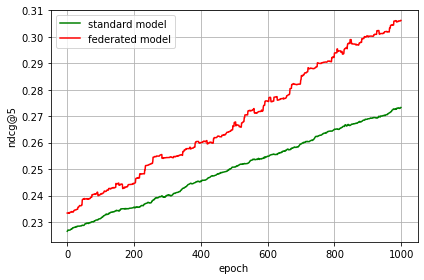

In [128]:
"""複数のグラフを重ねて描画するプログラム"""
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

t = range(1000)
y1 = classical_ndcg5
y2 = fed5

c1,c2 = "green","red"     # 各プロットの色
l1,l2 = "standard model","federated model"   # 各ラベル

ax.set_xlabel('epoch')  # x軸ラベル
ax.set_ylabel('ndcg@5')  # y軸ラベル
#ax.set_title(r'$\sin(x)$ and $\cos(x)$') # グラフタイトル
# ax.set_aspect('equal') # スケールを揃える
ax.grid()            # 罫線
#ax.set_xlim([-10, 10]) # x方向の描画範囲を指定
#ax.set_ylim([0, 1])    # y方向の描画範囲を指定
ax.plot(t, y1, color=c1, label=l1)
ax.plot(t, y2, color=c2, label=l2)
#ax.plot(t, y3, color=c3, label=l3)
#ax.plot(t, y4, color=c4, label=l4)
ax.legend(loc=0)    # 凡例
fig.tight_layout()  # レイアウトの設定
plt.savefig('fed4_ranknet.png') # 画像の保存
plt.show()

In [129]:
#fed
print(testing(combined_model, s5, 1))
print(testing(combined_model, s5, 5))

tensor(0.3284)
tensor(0.3458)


In [131]:
# classic
print(testing(classical_model, s5, 1))
print(testing(classical_model, s5, 5))

tensor(0.2579)
tensor(0.2892)


In [ ]:
set1_test_ndcg5
set2_test_ndcg5

---

In [ ]:
data_list=[fold1,fold2]

In [7]:
def training_loop(n_epochs,optimizer,model,data_list):
    count = 0
    best_ndcg = 0
    
    while count < len(data_list):
        # 最初の3つをtrainに
        train = data_list[0]+data_list[1]+data_list[2]
        # 1つをvalidationに
        val = data_list[3]
        # 最後をtestに
        test = data_list[4]
        
        # モデルの訓練
        for epoch in range(1, n_epochs + 1):
        
            # クエリごとの訓練
            batch_loss = 0
            batch_ndcg = 0
            for _,batch_ranking,label in train:
                batch_loss += model.forward(batch_ranking=batch_ranking, label=label)
                #print(compute_ndcg(batch_ranking,label,5))
                batch_ndcg += compute_ndcg(batch_ranking,label,5)
                    
            fold_loss_mean = batch_loss / (len(data_list[0])+len(data_list[1])+len(data_list[2]))
            fold_ndcg_mean = batch_ndcg / (len(data_list[0])+len(data_list[1])+len(data_list[2]))
            
            if epoch ==1 or epoch%10==0:
                print('epoch:{0}, loss:{1}, ndcg:{2}'.format(epoch, fold_loss_mean, fold_ndcg_mean))
            
            # パラメータ選択
            val_loss = 0
            val_ndcg = 0
            for _,batch_ranking,label in val:
                val_loss += model.forward(batch_ranking=batch_ranking, label=label)
                val_ndcg += compute_ndcg(batch_ranking,label,5)
                
            val_loss_mean = val_loss / len(val)
            val_ndcg_mean = val_ndcg / len(val)    
                
            if val_ndcg_mean > best_ndcg:
                best_ndcg = val_ndcg_mean
            
                # 訓練したモデルの保存
                torch.save(model.state_dict(), 'weight.pth')
            
            optimizer.zero_grad()
            fold_loss_mean.backward()
            optimizer.step()
            
        # パラメータの読み込み
        param = torch.load('weight.pth')
        model.load_state_dict(param)
        
        #test
        test_ndcg = testing(test)
        
        print('test:{0}'.format(test_ndcg))
        
        #　右にひとつシフト ([1,2,3,4,5] -> [5,1,2,3,4]となる)
        data_list.insert(0,data_list.pop())
        
#         if epoch%10==0:
#             print("epoch: ", epoch, "loss: ", epoch_loss, "ndcg: ", epoch_ndcg)
        count += 1

In [8]:
data_list = [fold1,fold2,fold3,fold4,fold5]

In [17]:
# クラスのインスタンス化
model = RankNet(layers)

In [10]:
training_loop(
    n_epochs = 100,
    optimizer = torch.optim.SGD(model.parameters(),lr = 0.01),
    model = model,
    data_list = data_list,
    )

epoch:1, loss:0.33804816007614136, ndcg:0.2129535973072052
epoch:10, loss:0.3380464017391205, ndcg:0.21400970220565796
epoch:20, loss:0.33804401755332947, ndcg:0.21507927775382996
epoch:30, loss:0.3380418121814728, ndcg:0.21627427637577057
epoch:40, loss:0.33803996443748474, ndcg:0.218105748295784
epoch:50, loss:0.33803796768188477, ndcg:0.21888558566570282
epoch:60, loss:0.33803579211235046, ndcg:0.2204192578792572
epoch:70, loss:0.3380337357521057, ndcg:0.22214770317077637
epoch:80, loss:0.3380317687988281, ndcg:0.2235986590385437
epoch:90, loss:0.338029682636261, ndcg:0.224581778049469
epoch:100, loss:0.33802759647369385, ndcg:0.225375235080719
test:0.2294071763753891
epoch:1, loss:0.33805733919143677, ndcg:0.23191629350185394
epoch:10, loss:0.3380555808544159, ndcg:0.2341095507144928
epoch:20, loss:0.3380531668663025, ndcg:0.2361796349287033
epoch:30, loss:0.33805134892463684, ndcg:0.23738986253738403
epoch:40, loss:0.33804914355278015, ndcg:0.23919181525707245
epoch:50, loss:0.338